# Classification

We will now train our first classifier.  We will use the titanic dataset for this.


Let's load the data using pandas as we learnt in the previous notebooks.

In [1]:
import pandas as pd
import numpy as np
# we are loading data from github. 
dataurl = 'https://github.com/rrr-uom-projects/MPiCRT-AI/raw/main/Data/titanic.csv' 
pax = pd.read_csv(dataurl, sep = ',')

We need to understand the data we have to start making sense of it. Here is a short description of the series:

- **PassengerId** Arbitrary nr between 1 and 841
- **Survived** Weather Survived or not: 0 = No, 1 = Yes
- **Pclass** Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
- **Name** Name of the Passenger
- **Sex** Female/male
- **Age** Age in years
- **SibSp** No. of siblings / spouses aboard the Titanic
- **Parch** No. of parents / children aboard the Titanic
- **Ticket** Ticket number
- **Fare** Passenger fare
- **Cabin** Cabin number
- **Embarked** Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton


Let's sort the categorical variables correctly here.

In [2]:
pax['Sex'] = pax['Sex'].astype('category')
pax['Survived'] = pax['Survived'].astype("category")
pax['Pclass'] = pax['Pclass'].astype("category")
pax['Embarked'] = pax['Embarked'].astype("category")

pax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 59.8+ KB


## Preprocessing

During the last tutorial we explored the data and extracted some extra bits from some variables.  Let's bring the relevant code here.

### Imputing Age

We learnt how to impute age accounting for Sex, Pclass, Embarked, etc. Let's copy the relevant code here:

In [3]:
medianAges = pax.groupby(['Sex','Pclass','Embarked'], observed=True)[['Age']].median()
medianAges = medianAges.reset_index()

def getMedianAgeForCategory(row):
    # using the dataframe medianAges created above.
    condition = (
        (medianAges['Sex'] == row['Sex']) & 
        (medianAges['Pclass'] == row['Pclass']) & 
        (medianAges['Embarked'] == row['Embarked'])
    ) 
    return medianAges[condition]['Age'].values[0]

def imputeIfNeeded(row):
    return getMedianAgeForCategory(row) if np.isnan(row['Age']) else row['Age']

#let's make a copy of the values before imputing
pax['Age'] = pax.apply(imputeIfNeeded, axis=1)
pax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 59.8+ KB


### Titles and tytle types
We also extracted titles from the passanger's name, and coded this title based on domain knowledge. 

Let's copy the relevant code here.

In [4]:
# First we need to cast the type of the Name series to str. 
pax['Name'] = pax['Name'].astype('string')
surnamefirstnames = pax['Name'].str.split(',')  # this splits the string by the token given (,)
pax['Surname'] = surnamefirstnames.str.get(0)   # here we get the first bit of the divided sentence
afterComma = surnamefirstnames.str.get(1).str.split('.')# this splits the string by the token given (.)
pax['Title'] = afterComma.str.get(0).str.strip()        # here we get the first bit of the divided sentence and eliminate empty spaces

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
pax['TitleType'] = pax['Title'].map(Title_Dictionary)
pax['TitleType'] = pax['TitleType'].astype('category')


### Family sizes and types
And we also created a new variable quantifying the size of the family for each passanger, and classified it in three classes: single, small family, large family. Let's bring the relevant code here:

In [5]:
pax['FamilySize'] = pax['SibSp']+pax['Parch']+1 
def getFamilyType(famsize):
    return 'single' if famsize == 1 else ('smallFamily' if famsize < 5 else 'largeFamily')

pax['FamilyType'] = pax['FamilySize'].apply(getFamilyType)
pax['FamilyType'] = pax['FamilyType'].astype('category')

## Eliminate variables 

Now we have extracted extra information from the data stored for each passanger. We can now clean up our dataframe in preparation to model training.

In [6]:
pax.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Surname', 'Title',
       'TitleType', 'FamilySize', 'FamilyType'],
      dtype='object')

In [7]:
pax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    string  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
 12  Surname      891 non-null    object  
 13  Title        891 non-null    object  
 14  TitleType    891 non-null    category
 15  FamilySize   891 non-null    int64   
 16  FamilyType   891 non-null    category
dtypes: category(6), float64(2), int64(4), object(4), string(1)
memory usage: 

In [8]:
cleanpax = pax.loc[:,['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'TitleType', 'FamilySize', 'FamilyType']]
cleanpax.dropna(inplace=True)
cleanpax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    889 non-null    category
 1   Pclass      889 non-null    category
 2   Sex         889 non-null    category
 3   Age         889 non-null    float64 
 4   SibSp       889 non-null    int64   
 5   Parch       889 non-null    int64   
 6   Fare        889 non-null    float64 
 7   Embarked    889 non-null    category
 8   TitleType   889 non-null    category
 9   FamilySize  889 non-null    int64   
 10  FamilyType  889 non-null    category
dtypes: category(6), float64(2), int64(3)
memory usage: 47.7 KB


# Data splitting

Before we do any training, let's divide the dataset in *training* and *validation*.  Ideally, we will have another dataset, *test*, to test for generalisability.  Kaggle kept a good portion of the data as test.  We won't use it in our tutorial.  But if you feel like seeing how generalisable are your models, join Kaggle and submit your solutions!

In [9]:
Y = cleanpax.loc[:,'Survived'] # This is the target!
X = cleanpax.loc[:, cleanpax.columns != 'Survived'] # This are the features/variables we wll use to predict

# to divide the data in train/validation, we an use train_test_split from sklearn
from sklearn.model_selection import train_test_split
X_train, x_val, Y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=1234) # train 80%, validation 20%

print(f'Features for train/validation datasets: {X_train.shape} and  {x_val.shape}' )
print(f'  In percentages: {100*X_train.shape[0]/pax.shape[0]:.2f}% and  {100*x_val.shape[0]/pax.shape[0]:.2f}%' )
survcounts = [Y_train.value_counts(),y_val.value_counts()]
print(f'Percentage survived for train/validation datasets: {100*survcounts[0][1]/Y_train.shape[0]:.2f}, {100*survcounts[1][1]/y_val.shape[0]:.2f}')

Features for train/validation datasets: (711, 10) and  (178, 10)
  In percentages: 79.80% and  19.98%
Percentage survived for train/validation datasets: 38.26, 38.20


We can use X_train and Y_train to create our models, and use x_test and y_test to test for overfitting!  We will learn more about this later.

# Further Data pre-processing
We will use SVM and RFC for our classifiers, as implemented in sklearn.  These implementation require all features converted to *numerical* features. So we need to convert the categorical values into numbers.

## Binary categories
First, let's do the binary categories: only two possible values are allowed.  In this case, one of the values can be mapped to 0 and the other one to 1.

In [10]:
X_train_num = X_train
X_train_num['Sex'] = X_train_num['Sex'].map({'male': 0, 'female': 1}).astype(int)

Y_train_num = Y_train.astype(int)


## Categories with multiple values
Categorical variables with multiple values are a bit more tricky. In this case, we can use the function get_dummies to convert them to a set of columns, one column per category value.  

In [11]:
X_train_num = pd.get_dummies(X_train_num, prefix='FamilyType',columns=['FamilyType'],dtype=int)
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 669 to 816
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Pclass                  711 non-null    category
 1   Sex                     711 non-null    int32   
 2   Age                     711 non-null    float64 
 3   SibSp                   711 non-null    int64   
 4   Parch                   711 non-null    int64   
 5   Fare                    711 non-null    float64 
 6   Embarked                711 non-null    category
 7   TitleType               711 non-null    category
 8   FamilySize              711 non-null    int64   
 9   FamilyType_largeFamily  711 non-null    int32   
 10  FamilyType_single       711 non-null    int32   
 11  FamilyType_smallFamily  711 non-null    int32   
dtypes: category(3), float64(2), int32(4), int64(3)
memory usage: 47.0 KB


In [12]:
X_train_num = pd.get_dummies(X_train_num, prefix='Embarked',columns=['Embarked'],dtype=int)
X_train_num = pd.get_dummies(X_train_num, prefix='TitleType',columns=['TitleType'],dtype=int)
X_train_num = pd.get_dummies(X_train_num, prefix='Pclass',columns=['Pclass'],dtype=int)

X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 669 to 816
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sex                     711 non-null    int32  
 1   Age                     711 non-null    float64
 2   SibSp                   711 non-null    int64  
 3   Parch                   711 non-null    int64  
 4   Fare                    711 non-null    float64
 5   FamilySize              711 non-null    int64  
 6   FamilyType_largeFamily  711 non-null    int32  
 7   FamilyType_single       711 non-null    int32  
 8   FamilyType_smallFamily  711 non-null    int32  
 9   Embarked_C              711 non-null    int32  
 10  Embarked_Q              711 non-null    int32  
 11  Embarked_S              711 non-null    int32  
 12  TitleType_Master        711 non-null    int32  
 13  TitleType_Miss          711 non-null    int32  
 14  TitleType_Mr            711 non-null    int32

We need to repeat the same operations to the validation dataset.

In [13]:
x_val_num = x_val
x_val_num['Sex'] = x_val_num['Sex'].map({'male': 0, 'female': 1}).astype(int)
x_val_num = pd.get_dummies(x_val_num, prefix='FamilyType',columns=['FamilyType'],dtype=int)
x_val_num = pd.get_dummies(x_val_num, prefix='Embarked',columns=['Embarked'],dtype=int)
x_val_num = pd.get_dummies(x_val_num, prefix='TitleType',columns=['TitleType'],dtype=int)
x_val_num = pd.get_dummies(x_val_num, prefix='Pclass',columns=['Pclass'],dtype=int)
print(x_val_num.info())

y_val_num = y_val.astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 608 to 126
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sex                     178 non-null    int32  
 1   Age                     178 non-null    float64
 2   SibSp                   178 non-null    int64  
 3   Parch                   178 non-null    int64  
 4   Fare                    178 non-null    float64
 5   FamilySize              178 non-null    int64  
 6   FamilyType_largeFamily  178 non-null    int32  
 7   FamilyType_single       178 non-null    int32  
 8   FamilyType_smallFamily  178 non-null    int32  
 9   Embarked_C              178 non-null    int32  
 10  Embarked_Q              178 non-null    int32  
 11  Embarked_S              178 non-null    int32  
 12  TitleType_Master        178 non-null    int32  
 13  TitleType_Miss          178 non-null    int32  
 14  TitleType_Mr            178 non-null    int32

# Support Vector Machines

Let's classify first with SVMs.  That means finding the best weights, bias and support vectors in the training dataset.  This is done easily using sklearn:

In [ ]:
from sklearn import svm

svmclassifier = svm.SVC(kernel="rbf", gamma=0.5, probability=True)
svmclassifier.fit(X_train_num, Y_train_num)  # here is where the magic happens ;-)


SVC(gamma=0.5, probability=True)

Let's see how good the training accuracy is:

In [ ]:
from sklearn import metrics
y_pred = svmclassifier.predict(X_train_num)

print( f'Training accuracy: {metrics.accuracy_score(Y_train, y_pred)}')

Training accuracy: 0.9592123769338959


## Evaluate the fit in the validation dataset

Now let's see how the model works for the data we kept apart:

In [ ]:
y_pred = svmclassifier.predict(x_val_num)

print( f'Validation accuracy: {metrics.accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.6685393258426966


There is a very large drop between the training accuracy and the validation accuracy... This means that we have overfitted... :( 

## Sometimes less is more!
Let's try with less variables.  We learnt that Sex, Age and Pclass were very strongly correlated to Survived in the previous tutorial... Let's see if this works better:

In [ ]:
X_train_small = X_train_num.loc[:,['Sex', 'Age', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
x_val_small = x_val_num.loc[:,['Sex', 'Age', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
svmclassifier.fit(X_train_small, Y_train_num)  

SVC(gamma=0.5, probability=True)

In [ ]:
y_pred = svmclassifier.predict(X_train_small)
print( f'Training accuracy: {metrics.accuracy_score(Y_train, y_pred)}')

y_pred = svmclassifier.predict(x_val_small)
print( f'Validation accuracy: {metrics.accuracy_score(y_val, y_pred)}')

Training accuracy: 0.8649789029535865
Validation accuracy: 0.8089887640449438


In this case, the drop is smaller, indicating that the simpler model is better at generalising.  
This shows that more data/more features is not always better!!

# Random Forest Classifiers

Let's explore now random forest classifiers.  
Let's choose 100 trees in the forest and to keep out-of-the-bag score for an idea of how well the training went.


In [32]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = RandomForestClassifier(n_estimators=100, oob_score=True)
rfclassifier.fit(X_train_num, Y_train_num.astype(int))

RandomForestClassifier(oob_score=True)

In [33]:
y_pred = rfclassifier.predict(X_train_num)
print( f'Training accuracy: {metrics.accuracy_score(Y_train, y_pred)}')

Training accuracy: 0.9831223628691983


## Evaluate the fit

In [35]:
y_pred = rfclassifier.predict(x_val_num)
print( f'Validation accuracy: {metrics.accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8370786516853933


What about having less features?

In [39]:
rf_small = RandomForestClassifier(n_estimators=100, oob_score=True)
rf_small.fit(X_train_small, Y_train_num.astype(int))

y_pred = rf_small.predict(X_train_small)
print( f'Training accuracy: {metrics.accuracy_score(Y_train, y_pred)}')
y_pred = rf_small.predict(x_val_small)
print( f'Validation accuracy: {metrics.accuracy_score(y_val, y_pred)}')


Training accuracy: 0.8959212376933896
Validation accuracy: 0.8033707865168539


In this case, the performance was not better with less figures. Trees are able to 'squeeze' more information from the other dimensions!  At the same time, you need to be more aware of overfitting!

## Feature importances
Another great feature of RFC is that you can investigate which features were used more frequently, which you could use to make the trees simpler.  Let's see this for the first forest we trained.

In [40]:
rfclassifier.feature_importances_

array([0.10581131, 0.2292478 , 0.02388676, 0.01845577, 0.20800046,
       0.03150237, 0.01382972, 0.01003405, 0.01949564, 0.01096354,
       0.00874417, 0.01108521, 0.0114752 , 0.04374096, 0.14072125,
       0.03003542, 0.00576655, 0.00159525, 0.02045427, 0.0126776 ,
       0.04247669])

Let's visualise them:

<Axes: >

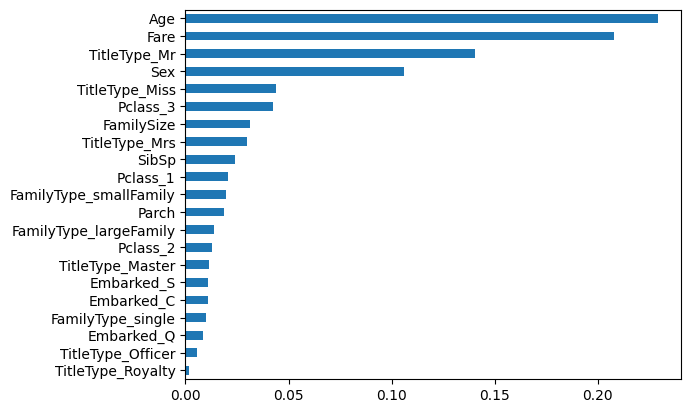

In [41]:
feature_imp = pd.Series(rfclassifier.feature_importances_, index=X_train_num.columns).sort_values(ascending=True)
feature_imp.plot(kind='barh')

# Other classification metrics
We can use classification_report() to get a summary of most common classification metrics.  Let's see these metrics for the RFCs:

In [42]:
y_pred = rfclassifier.predict(x_val_num)
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       110
           1       0.85      0.69      0.76        68

    accuracy                           0.84       178
   macro avg       0.84      0.81      0.82       178
weighted avg       0.84      0.84      0.83       178



You can find information on these metrics in the scikit-learn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics 

We are done for today!